**0 .Introduction**

Welcome to you for the best kernel of this competition. Coded by me Sémi Ben Hsan (SBH) .Machine Learning Intern at TalTech - Tallinn University of Technology . This kernel includes all the advanced techniques of Natural Language processing (NLP), programmed in a professional way ( The SBH style ) and explained in detail . I am waiting for your votes, opinions and comments ... If you use parts of this notebook in your scripts/notebooks, giving some kind of credit would be very much appreciated :) You can for instance link back to this notebook. Thanks!

**1 .Importations**

**2 .Utils**

**3 .Data Loading**

**4 .Data anomaly detection**

   *4 .1 Detecting the mislabeled tweets*
   
**5 .visualizations**

  *5 .1 Missing Values*
  
  *5 .2 % of 0 and 1 of the Target*
  
  *5 .3 caracter/word_level distribution*
  
  *5 .4 Word Cloud*
  
  *5. 5 Distribution of punctuation*
  
  *5.6 Most commun words*
  
  *5 .7 Plotting most frequent bigrams*
 
  *5 .8 Other features*
       
       
**6. Adding features**

  *6 .1 Meta features*
  
  *6.2 boxplot on the added features*
  
**7 .Data Cleaning**

  *7 .1 removing html tags and emojis etc*
  
  *7 .2 Spelling Correction*
  
  *7 .3 stemmer/Lemmer*
  
**8 . Feature Extractors**

  *8 .1 Tokenizer*
  
  *8 .2 CountVectorizer*
  
  *8 .3 Tfidf*
  
  *8 .4 Pipeline*
  
**9 Matrix Reduction**

**10 . Matrix_Embeddings**

**11 . Modeling**

   *11. 1 Catboost*
   
   *11 .2 Stacked Models*
   
   *11 .3 LSTM*
   
   *11 .4 Bert*

### **1 .Importations**

Starting by importing the useful libraries for this kernel 

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import string
special = string.punctuation 
warnings.filterwarnings("ignore")
from collections import  Counter
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) 
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **2 .Utils**

The Utils part: containing functions that will be useful for the whole kernel. The functions are in the order :  

Seed_everything : is used to initialize the random number generator.

load : used to load the data

Concat : used to concatenate train and test to avoid redundancy in the data clean 

divide_df :  function used to separate the train and the test after the data clean

List of words : function that returns the list of words that form the tweets

List_of_tweets : function that returns the list of all the tweets

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)

In [3]:
def load (path) : 
  df = pd.read_csv(path)
  return (df)

In [4]:
def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

In [5]:
def divide_df(df_all,train_len):
    return df_all.loc[:train_len-1], df_all.loc[train_len:].drop('target',axis=1)

In [6]:
from tqdm import tqdm 
def List_of_words(df): 
    words = [word for tweet in tqdm(df['text']) for word in tweet.split()]
    return words

In [7]:
def List_of_tweets(df):
    tweets = [tweet for tweet in tqdm(df['text']) ]
    return tweets

### **3 .Data Loading**

In [8]:
train = load('../input/nlp-getting-started/train.csv')
test = load('../input/nlp-getting-started/test.csv')

In [9]:
train.shape

(7613, 5)

### **4 .Data anomaly detection**

*4 .1 Detecting the mislabeled tweets*

There are 18 unique tweets in training set which are labeled differently in their duplicates. Those tweets are probably labeled by different people and they interpreted the meaning differently because some of them are not very clear. Tweets with two unique target values are relabeled since they can affect the training score.

In [10]:
def mislabeled_tweets (train) : # function that returns mislabeled labeled tweets
  df_mislabeled = train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
  df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
  return (df_mislabeled.index.tolist()) 

In [11]:
mislabeled_tweets (train)

['like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit',
 'Hellfire! We don\x89Ûªt even want to think about it or mention it so let\x89Ûªs not do anything that leads to it #islam!',
 "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!',
 'To fight bioterrorism sir.',
 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE',
 '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption',
 '#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect',
 'He came to a land which was engulfed in tribal war and turned it into a land 

In [12]:
 # function to correct mislabeled tweets
def correcting_labels (train) : 
  train['target_relabeled'] = train['target'].copy() 
  train.loc[train['text'] == 'like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit', 'target_relabeled'] = 0
  train.loc[train['text'] == 'Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife', 'target_relabeled'] = 0
  train.loc[train['text'] == 'To fight bioterrorism sir.', 'target_relabeled'] = 0
  train.loc[train['text'] == '.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4', 'target_relabeled'] = 1
  train.loc[train['text'] == 'CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring', 'target_relabeled'] = 1
  train.loc[train['text'] == '#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption', 'target_relabeled'] = 0
  train.loc[train['text'] == 'In #islam saving a person is equal in reward to saving all humans! Islam is the opposite of terrorism!', 'target_relabeled'] = 0
  train.loc[train['text'] == 'Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE', 'target_relabeled'] = 1
  train.loc[train['text'] == 'RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG', 'target_relabeled'] = 1
  train.loc[train['text'] == "Mmmmmm I'm burning.... I'm burning buildings I'm building.... Oooooohhhh oooh ooh...", 'target_relabeled'] = 0
  train.loc[train['text'] == "wowo--=== 12000 Nigerian refugees repatriated from Cameroon", 'target_relabeled'] = 0
  train.loc[train['text'] == "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam", 'target_relabeled'] = 0
  train.loc[train['text'] == "Hellfire! We donÛªt even want to think about it or mention it so letÛªs not do anything that leads to it #islam!", 'target_relabeled'] = 0
  train.loc[train['text'] == "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'", 'target_relabeled'] = 0
  train.loc[train['text'] == "Caution: breathing may be hazardous to your health.", 'target_relabeled'] = 1
  train.loc[train['text'] == "I Pledge Allegiance To The P.O.P.E. And The Burning Buildings of Epic City. ??????", 'target_relabeled'] = 0
  train.loc[train['text'] == "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect", 'target_relabeled'] = 0
  train.loc[train['text'] == "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time", 'target_relabeled'] = 0
  train.drop('target',axis= 1 , inplace=True ) 
  train.columns = ['id', 'keyword', 'location', 'text', 'target']

In [13]:
correcting_labels (train)

### **5 .visualizations**

*5 .1 Missing Values*

Let's take a look at the "Nans" of our data 

In [14]:
# function to return missing values
def missing_values(df): 
  total = df.isnull().sum().sort_values(ascending=False)


  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)

  missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
  f, ax = plt.subplots(figsize=(15, 6))
  plt.xticks(rotation='90')
  sns.barplot(x=missing_data.index, y=missing_data['Percent'])
  plt.xlabel('Features', fontsize=15)
  plt.ylabel('Percent of Missing Values', fontsize=15)
  plt.title('Percentage of Missing Data by Feature', fontsize=15)
  return (missing_data)


,Total,Percent
location,2533,0.332720
keyword,61,0.008013
id,0,0.000000
text,0,0.000000
target,0,0.000000


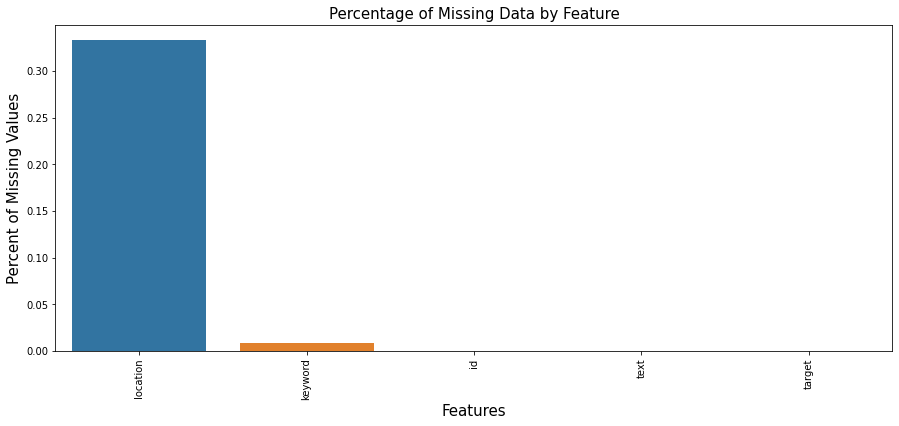

In [15]:
missing_values(train)
# missing_values(test)

Both training and test set have same ratio of missing values in keyword and location.

0.8% of keyword is missing in both training and test set
33% of location is missing in both training and test set
Since missing value ratios between training and test set are too close, they are most probably taken from the same sample. Missing values in those features are filled with no_keyword and no_location respectively.

*5 .2 % of 0 and 1 of the Target*

In [16]:
# function to plot the target _ distribution
def target_distribution (train) : 
  fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
  plt.tight_layout()

  train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
  sns.countplot(x=train['target'], hue=train['target'], ax=axes[1])

  axes[0].set_ylabel('')
  axes[1].set_ylabel('')
  axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
  axes[0].tick_params(axis='x', labelsize=15)
  axes[0].tick_params(axis='y', labelsize=15)
  axes[1].tick_params(axis='x', labelsize=15)
  axes[1].tick_params(axis='y', labelsize=15)

  axes[0].set_title('Target Distribution in Training Set', fontsize=13)
  axes[1].set_title('Target Count in Training Set', fontsize=13)

  plt.show()

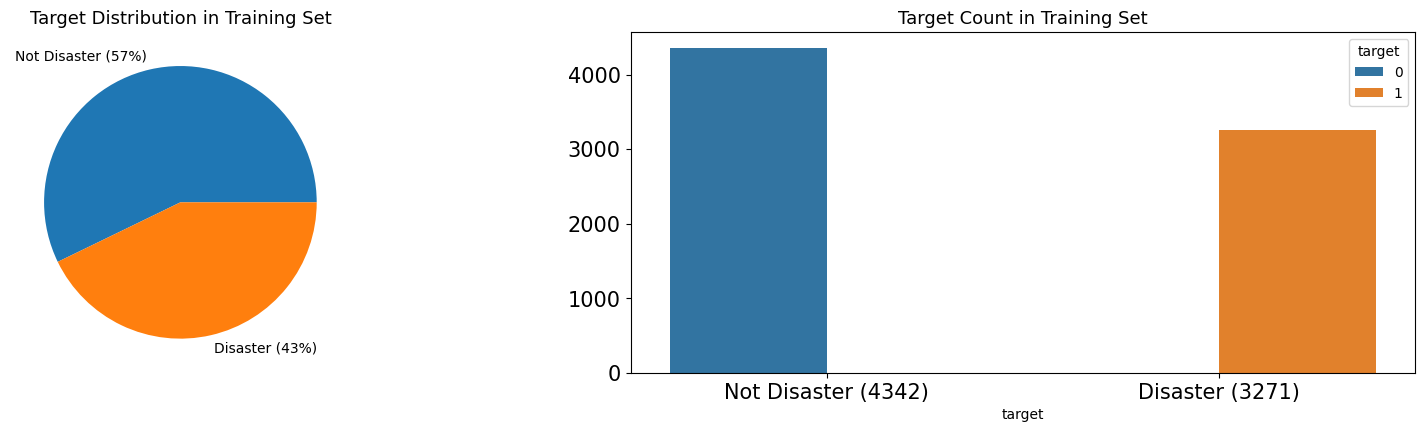

In [17]:
target_distribution (train)

43/100 Disaster tweets vs 57/100 Non disaster tweets We have a balanced data 

*5 .3 caracter/word_level distribution*

In [18]:
# function to plot the caracter _ distribution
def caracter_level_distrubtion (train): 
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
  tweet_len=train[train['target']==1]['text'].str.len() 
  ax1.hist(tweet_len,color='red')
  ax1.set_title('disaster tweets')
  tweet_len=train[train['target']==0]['text'].str.len()
  ax2.hist(tweet_len,color='green')
  ax2.set_title('Not disaster tweets')
  fig.suptitle('Characters in tweets')
  plt.show()


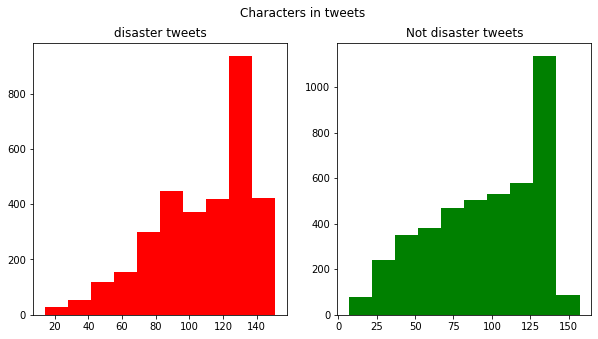

In [19]:
caracter_level_distrubtion (train)

The distribution of both seems to be almost same.120 t0 140 characters in a tweet are the most common among both.

In [20]:
# function to plot the word level distrubtion
def word_level_distrubtion (train): 
  fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
  tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
  ax1.hist(tweet_len,color='red')
  ax1.set_title('disaster tweets')
  tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
  ax2.hist(tweet_len,color='green')
  ax2.set_title('Not disaster tweets')
  fig.suptitle('Characters in tweets')
  plt.show()

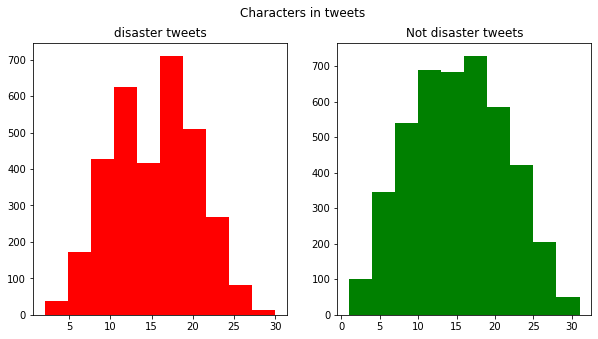

In [21]:
word_level_distrubtion (train)

*5 .4 Word Cloud*

Let's have some fun and plot the word cloud for the disaster and the non disaster tweets

In [22]:
from wordcloud import WordCloud
def WordCloud_plotting (train): 
  disaster_tweets = train[train['target']==0]['text']
  Non_disaster_tweets = train[train['target']==1]['text']
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
  wordcloud1 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(disaster_tweets)) 

  ax1.imshow(wordcloud1)
  ax1.axis('off')
  ax1.set_title('Disaster Tweets',fontsize=40);
  # Non disaster
  wordcloud2 = WordCloud( background_color='white',
                          width=600,
                          height=400).generate(" ".join(Non_disaster_tweets)) 

  ax2.imshow(wordcloud2)
  ax2.axis('off')
  ax2.set_title('Non Disaster Tweets',fontsize=40);

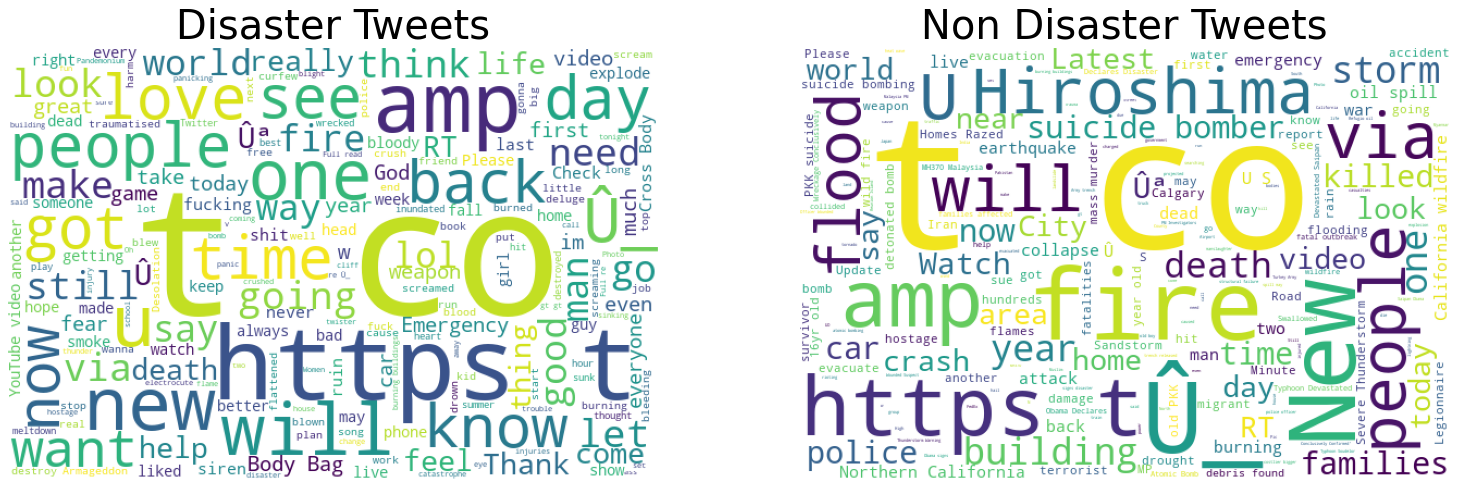

In [23]:
WordCloud_plotting (train)

*5. 5 Distribution of punctuation*

In [24]:
# function to return a dictionnary of punctuation_frequency
def punctuation_frequence(df) : 
  punct =defaultdict(int)
  for word in (List_of_words(df)):
      if word in special:
          punct[word]+=1
  return(punct)


In [25]:
punct = punctuation_frequence(train)

100%|██████████| 7613/7613 [00:00<00:00, 460715.02it/s]


In [26]:
# function to plot a barplot of punctuation
def punct_barplot (punct) : 
  x,y=zip(*punct.items())
  plt.bar(x,y,color='green')

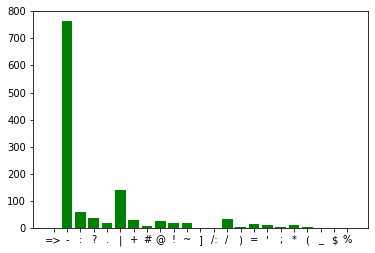

In [27]:
punct_barplot (punct)

*5.6 Most commun words*

In [28]:
# function to return the most common words
def most_common (df):
  counter=Counter(List_of_words(df))
  most=counter.most_common()
  x=[]
  y=[]
  for word,count in most[:70]: 
      if (word not in stop) :
          x.append(word)
          y.append(count)
  sns.barplot(x=y,y=x) 


100%|██████████| 7613/7613 [00:00<00:00, 476699.46it/s]


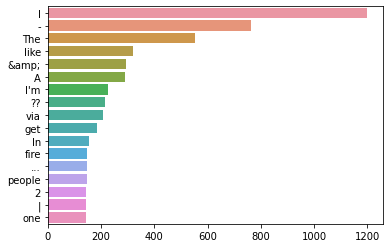

In [29]:
most_common (train)

*5 .7 Plotting most frequent bigrams*

In [30]:
# function to return the top n grams tweets
from sklearn.feature_extraction.text import CountVectorizer
def get_top_tweet_ngrams(corpus,n_gram,lenght): 
    vec = CountVectorizer(ngram_range=(n_gram, n_gram)).fit(corpus) 
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True) 
    return words_freq[:lenght] 

In [31]:
get_top_tweet_ngrams(List_of_tweets(train),4,10)

100%|██████████| 7613/7613 [00:00<00:00, 1045999.81it/s]


[('more homes razed by', 29),
 ('the latest more homes', 28),
 ('latest more homes razed', 28),
 ('homes razed by northern', 28),
 ('pkk suicide bomber who', 28),
 ('suicide bomber who detonated', 28),
 ('bomber who detonated bomb', 28),
 ('who detonated bomb in', 28),
 ('full re û_ http', 27),
 ('re û_ http co', 27)]

In [32]:
def plotting_top_ngrams (df): 
  plt.figure(figsize=(10,5))
  top_tweet_bigrams=get_top_tweet_ngrams(df['text'],4,10)[:10]
  x,y=map(list,zip(*top_tweet_bigrams))
  sns.barplot(x=y,y=x)   

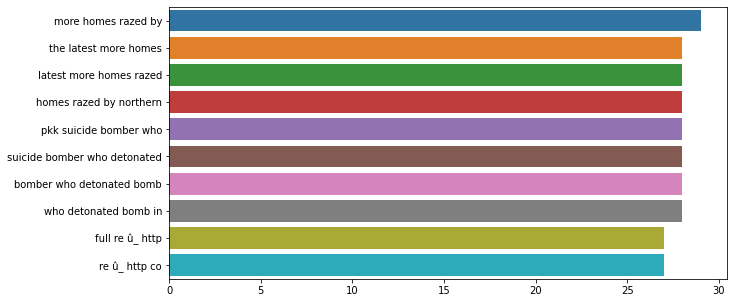

In [33]:
plotting_top_ngrams (train)

*5 .8 Other features*

*5 .8. 1 Keyword feature*

In [34]:
# function to plot keyword feature
def vis_per_feature (feature) : 
  train['target_mean'] = train.groupby(feature)['target'].transform('mean')
  fig = plt.figure(figsize=(8, 72), dpi=100)

  sns.countplot(y=train.sort_values(by='target_mean', ascending=False)[feature],
                hue=train.sort_values(by='target_mean', ascending=False)['target'])
  plt.tick_params(axis='x', labelsize=15)
  plt.tick_params(axis='y', labelsize=12)
  plt.legend(loc=1)
  plt.title('Target Distribution in Keywords')
  plt.show()
  train.drop(columns=['target_mean'], inplace=True)

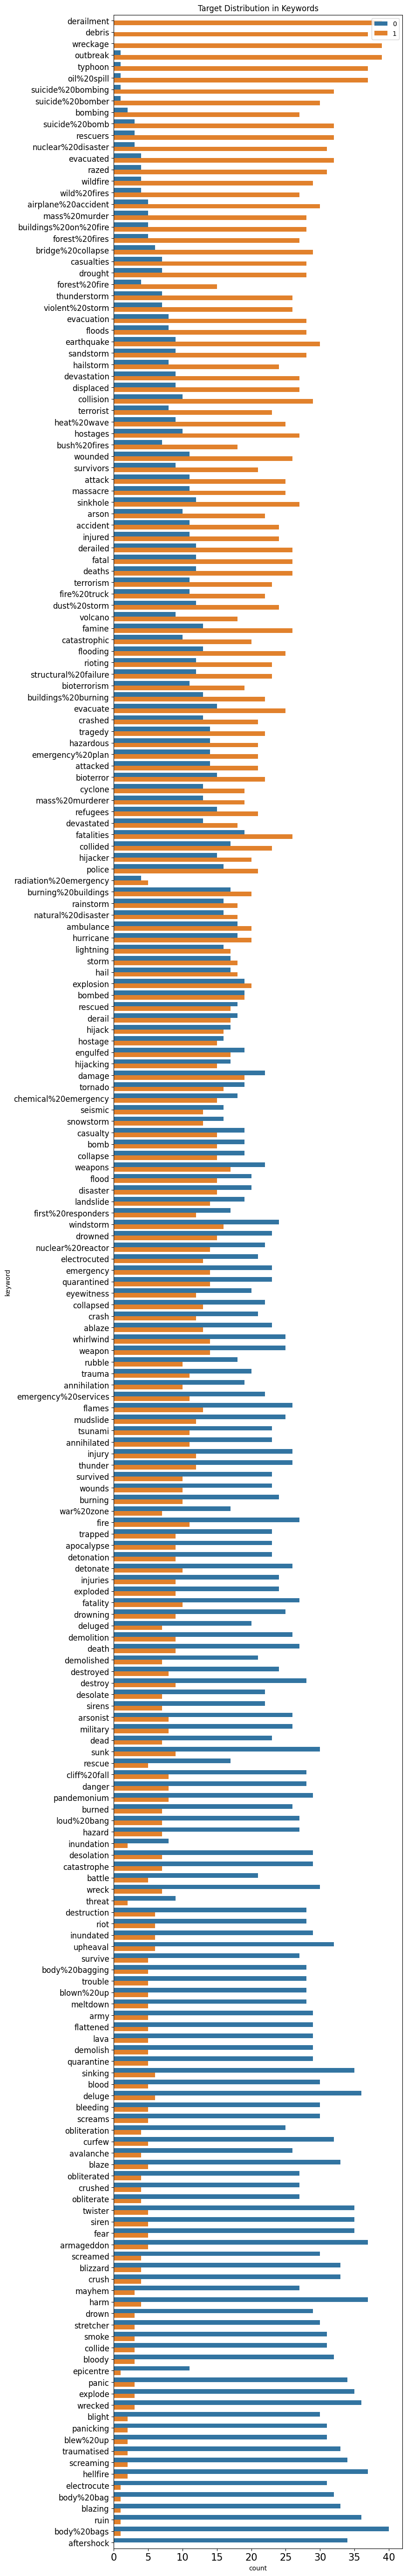

In [35]:
vis_per_feature ('keyword')

*5.8.2 Location feature*

Let's try some binging on the location feature

In [36]:
def location_binging (df):
  df['location'].replace({'United States':'USA',
                            'New York':'USA',
                              "London":'UK',
                              "Los Angeles, CA":'USA',
                              "Washington, D.C.":'USA',
                              "California":'USA',
                              "Chicago, IL":'USA',
                              "Chicago":'USA',
                              "New York, NY":'USA',
                              "California, USA":'USA',
                              "FLorida":'USA',
                              "Nigeria":'Africa',
                              "Kenya":'Africa',
                              "Everywhere":'Worldwide',
                              "San Francisco":'USA',
                              "Florida":'USA',
                              "United Kingdom":'UK',
                              "Los Angeles":'USA',
                              "Toronto":'Canada',
                              "San Francisco, CA":'USA',
                              "NYC":'USA',
                              "Seattle":'USA',
                              "Earth":'Worldwide',
                              "Ireland":'UK',
                              "London, England":'UK',
                              "New York City":'USA',
                              "Texas":'USA',
                              "London, UK":'UK',
                              "Atlanta, GA":'USA',
                              "Mumbai":"India"},inplace=True)

In [37]:
location_binging (train)
location_binging (test)

In [38]:
# vis_per_feature ('location') 

### **6.  Adding features**

*6 .1 Meta features*

 The meta features used for the analysis are :
word_count: number of words in text

unique_word_count: number of unique words in text

stop_word_count: number of stop words in text

url_count number: of urls in text

mean_word_length: average character count in words

char_count number: of characters in text

punctuation_count: number of punctuations in text

hashtag_count: number of hashtags (#) in text

mention_count number of mentions (@) in text


In [39]:
df_all = concat_df(train,test)

In [40]:
# word_count
def word_count(df_all) : 
  df_all['word_count'] = df_all['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
def unique_word_count (df_all) : 
  df_all['unique_word_count'] = df_all['text'].apply(lambda x: len(set(str(x).split())))  

# stop_word_count
def stop_word_count (df_all) : 
  df_all['stop_word_count'] = df_all['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('english')]))

# url_count
def url_count(df_all) : 
  df_all['url_count'] = df_all['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
def mean_word_length (df_all) : 
  df_all['mean_word_length'] = df_all['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
def char_count (df_all) : 
  df_all['char_count'] = df_all['text'].apply(lambda x: len(str(x)))

# punctuation_count
def punctuation_count (df_all) : 
  df_all['punctuation_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
def hashtag_count(df_all) : 
  df_all['hashtag_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
def mention_count(df_all) : 
  df_all['mention_count'] = df_all['text'].apply(lambda x: len([c for c in str(x) if c == '@']))


In [41]:
word_count(df_all) 
unique_word_count (df_all)  
stop_word_count (df_all) 
url_count(df_all) 
mean_word_length (df_all) 
char_count (df_all) 
punctuation_count (df_all)
hashtag_count(df_all) 
mention_count(df_all)

In [42]:
train , test  =  divide_df(df_all,train.shape[0])

*6.2 boxplot on the added features*

Let's do some boxplot in order to have an idea on the added features

In [43]:
def box_plot_for_meta_features (train,f1,f2,f3) :
  f, axes = plt.subplots(3, 1, figsize=(10,20))
  sns.boxplot(x='target', y=f1, data=train, ax=axes[0])
  axes[0].set_xlabel('Target', fontsize=12)
  axes[0].set_title("Number of " + f1.split('_')[0] + " in each class", fontsize=15)

  sns.boxplot(x='target', y=f2, data=train, ax=axes[1])
  axes[1].set_xlabel('Target', fontsize=12)
  axes[1].set_title("Number of" + f2.split('_')[0] + "in each class", fontsize=15)

  sns.boxplot(x='target', y=f3, data=train, ax=axes[2])
  axes[2].set_xlabel('Target', fontsize=12)
  axes[2].set_title("Number of " + f3.split('_')[0] + " in each class", fontsize=15)
  plt.show()

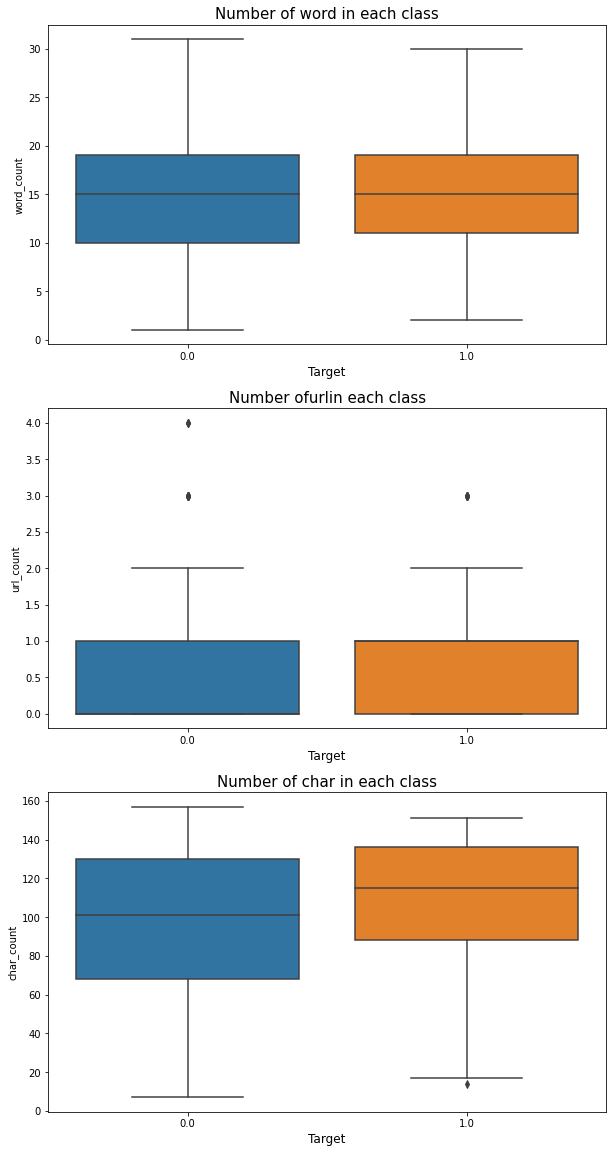

In [44]:
box_plot_for_meta_features (train,'word_count','url_count','char_count')

In [45]:
def plotting_MetaFeatures (train): 
  METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                  'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
  DISASTER_TWEETS = train['target'] == 1

  fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

  for i, feature in enumerate(METAFEATURES):
      sns.distplot(train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
      sns.distplot(train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

      sns.distplot(train[feature], label='Training', ax=axes[i][1])
      sns.distplot(test[feature], label='Test', ax=axes[i][1])
      
      for j in range(2):
          axes[i][j].set_xlabel('')
          axes[i][j].tick_params(axis='x', labelsize=12)
          axes[i][j].tick_params(axis='y', labelsize=12)
          axes[i][j].legend()
      
      axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
      axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

  plt.show()

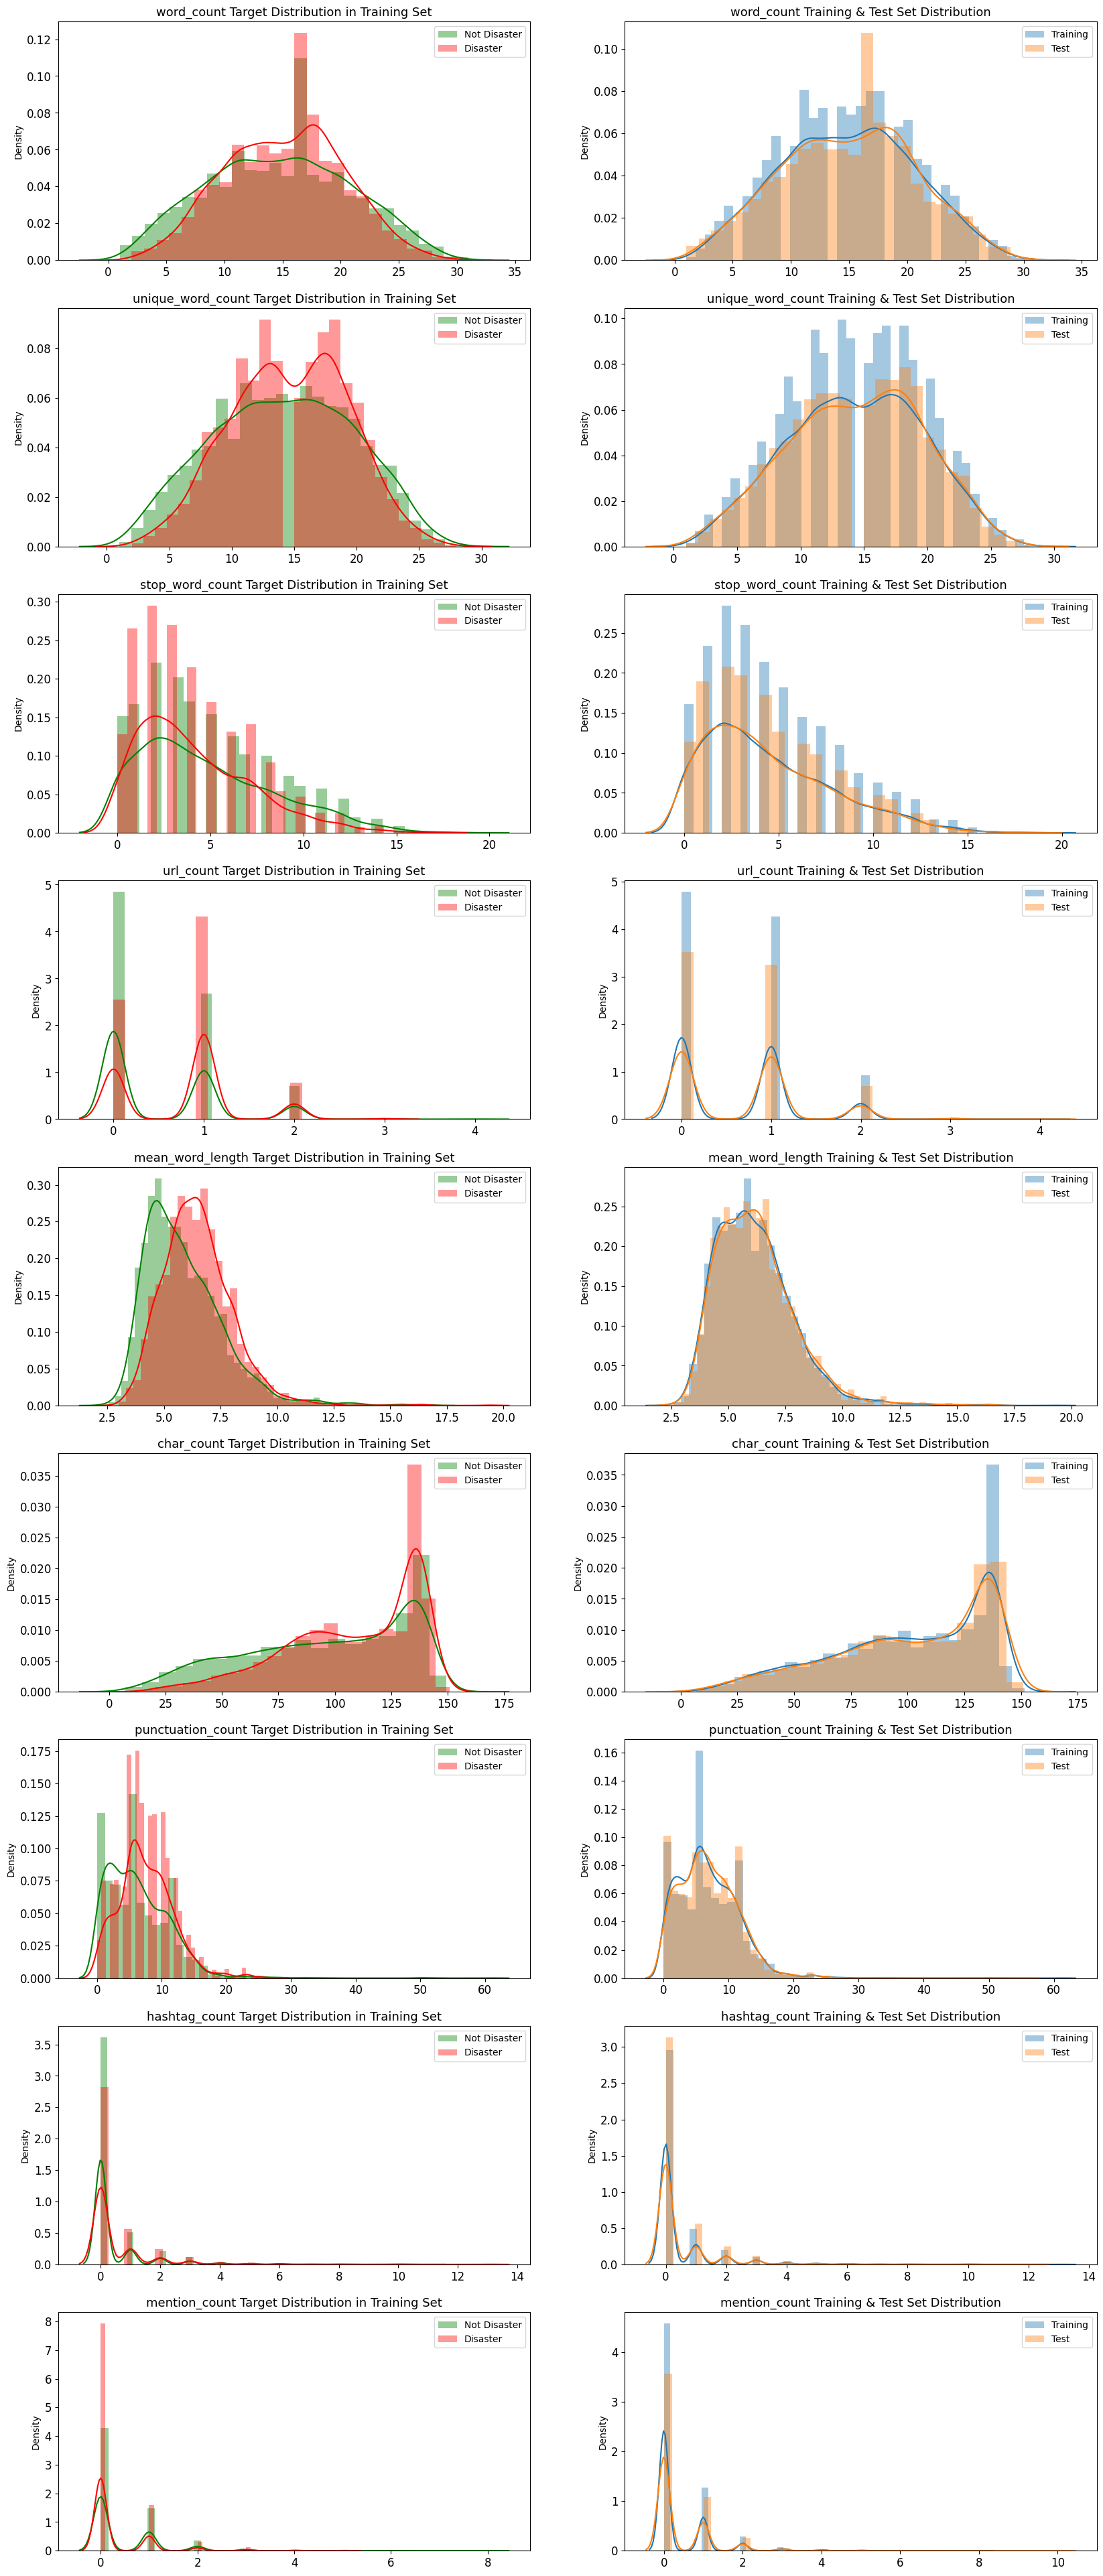

In [46]:
plotting_MetaFeatures (train)

All of the meta features have very similar distributions in training and test set which also proves that training and test set are taken from the same sample.

All of the meta features have information about target as well, but some of them are not good enough such as url_count, hashtag_count and mention_count.

On the other hand, word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count have very different distributions for disaster and non-disaster tweets. Those features might be useful in models

### **7 .Data Cleaning**

*7 .1 removing html tags and emojis etc*

As we know,twitter tweets always have to be cleaned before we go onto modelling.So we will do some basic cleaning such as spelling correction,removing punctuations,removing html tags and emojis etc.So let's start.

In [47]:
#remove stop words
def remove_stops(text) : 
  remove_stopwords = [w for w in text.split() if w not in stopwords.words('english')]
  return ' '.join(remove_stopwords)

In [48]:
# remove URLs
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

In [49]:
# remove htmls
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [50]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [51]:
# remove punct
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [52]:
# remove other ...
def remove_other (text) : 
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return(text)

You have the choice here, to use some clean functions, or the full clean function with all the functions coded before 

In [53]:
# Full clean ... combination off all the previous functions
def Full_clean (text) : 
  text = remove_stops(text)
  text = remove_URL(text)
  text = remove_html(text)
  text = remove_emoji(text)
  text = remove_punct(text)
  text = remove_other (text)
  return(text)

In [54]:
df_all['text'] = df_all['text'].apply(lambda x : Full_clean(x))

*7 .2 Spelling Correction*

Even if I'm not good at spelling I can correct it with python :) I will use pyspellcheker to do that.

In [55]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 1.3 MB/s 


In [56]:
# function to take a text and correct it 
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split()) 
    for word in text.split(): 
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [57]:
# df_all['text'] = df_all['text'].apply(lambda x : correct_spellings(x))

*7 .3 stemmer/Lemmer*

In [58]:
# fonction to stemm the text
def stemming (text) : 
  stemmer = nltk.stem.PorterStemmer()
  return(" ".join(stemmer.stem(word) for word in text.split()))

In [59]:
# function to lemm a text 
def lemming (text) : 
  lemmatizer=nltk.stem.WordNetLemmatizer()
  return(" ".join(lemmatizer.lemmatize(word) for word in text.split()))

In [60]:
df_all['text'] = df_all['text'].apply(lambda x : stemming(x))
# df_all['text'] = df_all['text'].apply(lambda x : lemming(x))

Why is Lemmatization better than Stemming? Stemming algorithm works by cutting the suffix from the word. In a broader sense cuts either the beginning or end of the word.

### **8 . Feature Extractors**

The data clean phase is over. We can now separate the train and test. We use divide_df for that 

In [61]:
train , test = divide_df(df_all,train.shape[0])

We can then proceed to the feature extraction phase. We will use 3 Feature extractors :

8.1 Tokenizer

8.2 CountVectorizer

8.3 Tfidf

*8 .1 Tokenizer*

Tokenization is the process of tokenizing or splitting a string, text into a list of tokens. One can think of token as parts like a word is a token in a sentence, and a sentence is a token in a paragraph

In [62]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# return a fitted tokenizer 
def tokenization (train)  : 
  tokenizer =Tokenizer()
  tokenizer.fit_on_texts(List_of_tweets(train))
  return(tokenizer)

In [63]:
tokenizer = tokenization(train) 

100%|██████████| 7613/7613 [00:00<00:00, 1225579.04it/s]


In [64]:
# function to prepare the sequences by the tokenizer 
def preparing_sequences(tokenizer) : 
  train_sequences = tokenizer.texts_to_sequences(List_of_tweets(train))
  test_sequences = tokenizer.texts_to_sequences(List_of_tweets(test))
  return train_sequences , test_sequences

In [65]:
train_sequences , test_sequences = preparing_sequences(tokenizer)

100%|██████████| 3263/3263 [00:00<00:00, 1228326.51it/s]


In [66]:
# a function to padd the sequences 
def padding_sequences (train_sequences, test_sequences):
  train_sequences = pad_sequences(train_sequences,25,padding='post', truncating='post')
  test_sequences = pad_sequences(test_sequences,25,padding='post', truncating='post')
  return train_sequences , test_sequences

In [67]:
train_sequences , test_sequences = padding_sequences (train_sequences, test_sequences)

In [68]:
# function to return the train / test matrix
def sequences_to_matrix (train_sequences,test_sequences) : 
  train_matrix = np.vstack(train_sequences)
  test_matrix = np.vstack(test_sequences)
  return train_matrix , test_matrix

In [69]:
train_matrix , test_matrix = sequences_to_matrix (train_sequences,test_sequences)

*8 .2 CountVectorizer*

CountVectorizer converts a collection of text documents to a matrix of token counts: the occurrences of tokens in each document. This implementation produces a sparse representation of the counts.

In [70]:
# function to return a fitted countvectorizer
from sklearn.feature_extraction.text import CountVectorizer
def countvectorizer (train) : 
  count_vectorizer = CountVectorizer() 
  count_vectorizer.fit(List_of_tweets(train))
  return  count_vectorizer

In [71]:
count_vectorizer = countvectorizer (train) 

100%|██████████| 7613/7613 [00:00<00:00, 1331133.75it/s]


In [72]:
# function to prepare matrix with countvectorizer
def preparing_matrix_countvectorizer (count_vectorizer):
  train_matrix = count_vectorizer.transform(List_of_tweets(train))
  test_matrix = count_vectorizer.transform(List_of_tweets(test))
  return train_matrix.toarray() , test_matrix.toarray()

In [73]:
train_matrix , test_matrix = preparing_matrix_countvectorizer (count_vectorizer)

100%|██████████| 3263/3263 [00:00<00:00, 876634.25it/s]


*8 .3 Tfidf*

With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the TF-IDF scores.

In [74]:
# function to return the train/test matrix with tfidf 
from sklearn.feature_extraction.text import TfidfTransformer
def tfidf_fit (train_matrix , test_matrix) : 
  train_matrix = TfidfTransformer().fit_transform(train_matrix)
  test_matrix = TfidfTransformer().fit_transform(test_matrix)
  return train_matrix.toarray() , test_matrix.toarray()

In [75]:
 train_matrix , test_matrix = tfidf_fit (train_matrix , test_matrix)

*8 .4 Pipeline*

In [76]:
# if you want to use the Full pipe line  (countvectorizer + Tfidf)
from sklearn.pipeline import Pipeline
def Full_pip (train) : 
   pipe = Pipeline([('count', CountVectorizer()),
                    ('tfid', TfidfTransformer())])
   pipe.fit(List_of_tweets(train))
   return(pipe)


In [77]:
pipe = Full_pip (train)

100%|██████████| 7613/7613 [00:00<00:00, 1276891.92it/s]


In [78]:

def preparing_matrix_pipe (pipe):
   train_matrix =  pipe.transform(List_of_tweets(train))
   test_matrix =  pipe.transform(List_of_tweets(test))
   return train_matrix.toarray(),test_matrix.toarray()

In [79]:
train_matrix,test_matrix = preparing_matrix_pipe (pipe)

100%|██████████| 3263/3263 [00:00<00:00, 1251235.50it/s]


### **9  Matrix Reduction**

in order to reduce the dimensionality of our matrix ! [Feature matrix shape: Number of documents x Length of vocabulary ] we can carry out some Feature Selection, the process of selecting a subset of relevant variables. I will proceed as follows:

treat each category as binary (for example, the “Tech” category is 1 for the Tech news and 0 for the others); perform a Chi-Square test to determine whether a feature and the (binary) target are independent; keep only the features with a certain p-value from the Chi-Square test.

In [80]:
from sklearn import feature_selection 
def Best_feature_extractor (train,count_vectorizer,train_matrix):
  y = train['target']
  Best_X_names = count_vectorizer.get_feature_names()
  p_value_limit = 0.95
  dtf_features = pd.DataFrame()
  for cat in np.unique(y):
      chi2, p = feature_selection.chi2(train_matrix, y==cat)
      dtf_features = dtf_features.append(pd.DataFrame(
                    {"feature":Best_X_names, "score":1-p, "y":cat}))
      dtf_features = dtf_features.sort_values(["y","score"], 
                      ascending=[True,False])
      dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
  Best_X_names = dtf_features["feature"].unique().tolist()
  return(Best_X_names)


In [81]:
Best_X_names = Best_feature_extractor (train,count_vectorizer,train_matrix)

In [82]:
def columns_index (Best_X_names,count_vectorizer): 
  columns_index_to_preserve = [count_vectorizer.vocabulary_[x] for x in Best_X_names ]
  return columns_index_to_preserve

In [83]:
columns_index_to_preserve = columns_index (Best_X_names,count_vectorizer)

In [84]:
def reducing_matrix (train_matrix,test_matrix , columns_index_to_preserve): 
  train_matrix = train_matrix[:, columns_index_to_preserve ] 
  test_matrix = test_matrix[:, columns_index_to_preserve ] 
  return train_matrix , test_matrix


In [85]:
train_matrix , test_matrix = reducing_matrix (train_matrix,test_matrix , columns_index_to_preserve)

### **10 . Matrix_Embeddings**

Here I will use GloVe pretrained corpus model to represent our words.It is available in 3 varieties :50D ,100D and 200 Dimentional.I will try 100 D here.



In [86]:
# function to return a dictionnary with (key,embedding vectors)
def embedding_vectors (path) : 
  embedding_dict={}
  with open(path,'r') as f:
      for line in f:
          values=line.split()
          word=values[0]
          vectors=np.asarray(values[1:],'float32')
          embedding_dict[word]=vectors
  f.close()
  return embedding_dict

In [87]:
embedding_dict = embedding_vectors ('../input/glove6b100dtxt/glove.6B.100d.txt')

In [88]:
# function to return an embedding matrix given a dictionnary
def matrix_embedding (dict_vocabulary) : 
  num_words=len(dict_vocabulary)+1
  embedding_matrix=np.zeros((num_words,100)) 

  for word,i in tqdm(dict_vocabulary.items()):
      if i > num_words:  
          continue
      
      emb_vec=embedding_dict.get(word)
      if emb_vec is not None:
          embedding_matrix[i]=emb_vec
  return embedding_matrix

In [89]:
embedding_matrix = matrix_embedding(count_vectorizer.vocabulary_)

100%|██████████| 13380/13380 [00:00<00:00, 371895.58it/s]


### **11 . Modeling**

We start with the catboost model with the StratifiedKFold . A sofisticated implementation in SBH style that can inspire you in your future kernels 

**9. 1 Catboost**

In [90]:
import os, sys, gc, warnings, random
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import lightgbm as lgb  
from catboost import CatBoostClassifier
from sklearn.metrics import auc, classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [91]:
# a class to fix the params 
class CFG :
  SEED = 42
  n_splits = 5
  catboost_params = {'learning_rate':0.05,'iterations':10000,'eval_metric':'AUC',
                      'use_best_model' :True,'verbose':100,'random_seed': 0}
  TARGET_COL = 'target'


In [92]:
seed_everything(CFG.SEED)


In [93]:
# return the Skf object 
def Stratified_object (n_splits= CFG.n_splits,seed = CFG.SEED):
  skf = StratifiedKFold(n_splits=CFG.n_splits,shuffle=True, random_state=CFG.SEED)
  return (skf)


In [94]:
skf = Stratified_object ()

In [95]:
# full training with skf
def Stratified_training (train,train_matrix,test_matrix,skf):
  X , y = train_matrix , train['target']
  oof_cat = np.zeros((train.shape[0],)) 
  test['target'] = 0
  cat_preds= []
  for fold_ , (trn_idx, val_idx) in enumerate(skf.split(X, y)):
      print(50*'-')
      print('Fold:',fold_+1)
      X_train, y_train = X[trn_idx,:], y[trn_idx] 
      X_test, y_test = X[val_idx,:], y[val_idx] 
        
      estimator = CatBoostClassifier(**CFG.catboost_params)
      estimator.fit(X_train,y_train,
                    eval_set =(X_test,y_test),early_stopping_rounds=200)
      
      y_pred_val = estimator.predict_proba(X_test)[:,1]
      oof_cat[val_idx] = y_pred_val
      y_pred_test = estimator.predict_proba(test_matrix)[:,1]
      cat_preds.append(y_pred_test)
      print(50*'-')
      print()
  print('OOF score :',roc_auc_score(y, oof_cat))
  return cat_preds


In [96]:

cat_preds = Stratified_training (train,train_matrix,test_matrix,skf)

--------------------------------------------------
Fold: 1
0:	test: 0.5619642	best: 0.5619642 (0)	total: 65.9ms	remaining: 10m 59s
100:	test: 0.8074379	best: 0.8076272 (97)	total: 1.19s	remaining: 1m 57s
200:	test: 0.8231336	best: 0.8231336 (200)	total: 2.32s	remaining: 1m 53s
300:	test: 0.8368994	best: 0.8368994 (300)	total: 3.51s	remaining: 1m 53s
400:	test: 0.8411696	best: 0.8414188 (384)	total: 4.64s	remaining: 1m 51s
500:	test: 0.8430327	best: 0.8430749 (499)	total: 5.78s	remaining: 1m 49s
600:	test: 0.8422816	best: 0.8432625 (507)	total: 6.93s	remaining: 1m 48s
700:	test: 0.8429279	best: 0.8432625 (507)	total: 8.07s	remaining: 1m 47s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8432624513
bestIteration = 507

Shrink model to first 508 iterations.
--------------------------------------------------

--------------------------------------------------
Fold: 2
0:	test: 0.5764952	best: 0.5764952 (0)	total: 13.6ms	remaining: 2m 15s
100:	test: 0.8069184	best: 0.80

In [97]:
catboost_preds = np.mean(cat_preds,axis=0)


In [98]:
catboost_preds.shape

(3263,)

**11 .2 Stacked Models**

In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.

The procedure, for the training part, may be described as follows:

Split the total training set into two disjoint sets (here train and .holdout )

Train several base models on the first part (train)

Test these base models on the second part (holdout)

Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

In [99]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [100]:
#Validation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [102]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='deviance', random_state =5)

In [103]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

In [104]:
stacked_averaged_models.fit(train_matrix, train['target'].values)
stacked_train_pred = stacked_averaged_models.predict(train_matrix)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_matrix))


In [105]:
print(rmsle(train['target'], stacked_train_pred))

0.3740790525320356


**11 .3 LSTM**

Here I will just introduce the use of LSTM coupled with Embeddings vectors ... You can continue with a lot of changes here... Adding more LSTM, GRU, or RNN layers... 

In [106]:
import keras
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant

In [107]:
class LSTM_Model(keras.Model):
  def __init__(self,num_words,embedding_matrix ,MAX_LEN,nodes): 
    super(LSTM_Model, self).__init__()
    self.embedding = Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)
    self.dropout = SpatialDropout1D(0.2)
    self.block = LSTM(nodes, dropout=0.2, recurrent_dropout=0.2)
    self.Classifier = Dense(2, activation='sigmoid') 
  def call(self,matrix): 
    x = self.embedding(matrix)
    x = self.block(x)
    x = self.dropout(x)
    x = self.Classifier(x)
    return (x)


In [108]:
# model = LSTM_Model(len(count_vectorizer.vocabulary_)+1,MAX_LEN=50,nodes=64)

In [109]:
# model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(0.1),metrics=['accuracy'])


In [110]:
# history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

**11 .4 Bert**

BERT is an open source machine learning framework for natural language processing (NLP). BERT is designed to help computers understand the meaning of ambiguous language in text by using surrounding text to establish context. The BERT framework was pre-trained using text from Wikipedia and can be fine-tuned with question and answer datasets.

BERT, which stands for Bidirectional Encoder Representations from Transformers, is based on Transformers, a deep learning model in which every output element is connected to every input element, and the weightings between them are dynamically calculated based upon their connection. (In NLP, this process is called attention.)

In our case I will apply Bert as indicated in the code but for more details you can consult these links for the explanation of the paper: 
BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
https://www.youtube.com/watch?v=-9evrZnBorM&t=745s


In [111]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub

In [112]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [113]:
import tokenization

In [114]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [115]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [116]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 26.2 s, sys: 7.28 s, total: 33.4 s
Wall time: 36.1 s


In [117]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [118]:
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [119]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [120]:
# train_history = model.fit(
#     train_input, train_labels,
#     validation_split=0.2,
#     epochs=3,
#     batch_size=16
# )

# model.save('model.h5')

In [121]:
# test_pred = model.predict(test_input)


I'll stop here with this block of tips. Many techniques can be combined to obtain a high quality solution. Don't forget to put an UPvote for SBH to continue updating this notebook with other useful tips 